# Import

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import statsmodels.api as sm
import cv2

import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import InceptionResNetV2, DenseNet201
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Recall

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = "/content/gdrive/MyDrive/Applied Ai in Biomedicine/Progetto/VitAIizers/augmented_data_jan_1/nod/2_class_problem/"
# path = "/content/gdrive/MyDrive/VitAIizers/augmented_data_jan_1/nod/2_class_problem/"


X_train = np.load(path + "nod_training_augmented_images_two_class.npy")
y_train_complete = np.load(path + "nod_training_augmented_labels_two_class.npy")

y_train = np.zeros_like(y_train_complete)
y_train[y_train_complete >= 4] = 1
y_train[y_train_complete < 4] = 0

X_val = np.load(path + "nod_validation_set_two_class.npy")
y_val_complete = np.load(path + "nod_validation_set_labels_two_class.npy")

y_val = np.zeros_like(y_val_complete)
y_val[y_val_complete >= 4] = 1
y_val[y_val_complete < 4] = 0

X_test = np.load(path + "nod_test_set_two_class.npy")
y_test_complete = np.load(path + "nod_test_set_labels_two_class.npy")

y_test = np.zeros_like(y_test_complete)
y_test[y_test_complete >= 4] = 1
y_test[y_test_complete < 4] = 0

X_train = np.expand_dims(X_train, axis=-1)  # Aggiunge il canale come ultima dimensione
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4360, 224, 224, 1),
 (4360,),
 (237, 224, 224, 1),
 (237,),
 (237, 224, 224, 1),
 (237,))

In [ ]:
sigma_ratio_value = 5
# Custom Layer per la Maschera Gaussiana
class GaussianMaskLayer(tf.keras.layers.Layer):
    def __init__(self, sigma_ratio=sigma_ratio_value, **kwargs):
        super(GaussianMaskLayer, self).__init__(**kwargs)
        self.sigma_ratio = sigma_ratio
        self.mask = None  # Verrà calcolata una volta

    def build(self, input_shape):
        h, w = input_shape[1], input_shape[2]
        y, x = tf.meshgrid(tf.range(h, dtype=tf.float32), tf.range(w, dtype=tf.float32), indexing='ij')

        center = (h // 2, w // 2)  # Centro della maschera
        sigma = tf.cast(min(h, w) / self.sigma_ratio, tf.float32)

        self.mask = tf.exp(-((x - center[1])**2 + (y - center[0])**2) / (2 * sigma**2))
        self.mask = self.mask / tf.reduce_max(self.mask)  # Normalizza tra 0 e 1
        self.mask = tf.expand_dims(self.mask, axis=-1)  # Aggiunge il canale per il broadcasting

    def call(self, inputs):
        return inputs * self.mask

    def get_config(self):  # Per salvare e caricare il modello
        config = super().get_config()
        config.update({"sigma_ratio": self.sigma_ratio})
        return config


# Train

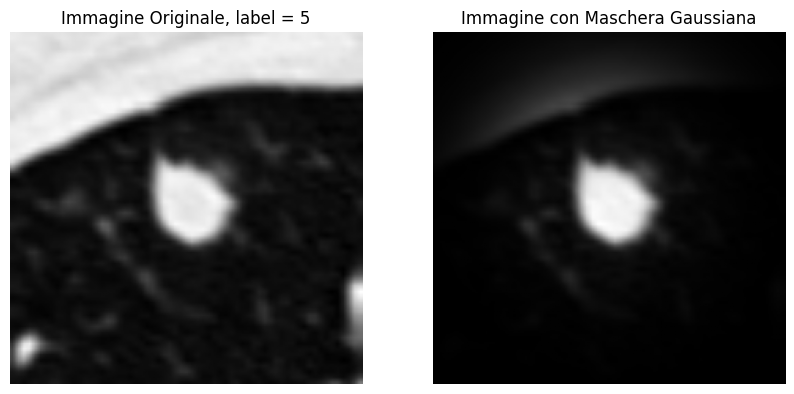

In [ ]:
def gaussian_mask(shape, sigma_ratio=5.0, center=None):
    h, w = shape[:2]
    y, x = np.ogrid[:h, :w]

    # Definisci il centro della maschera (default: centro dell'immagine)
    if center is None:
        center = (h // 2, w // 2)

    y = y - center[0]
    x = x - center[1]

    sigma = min(h, w) / sigma_ratio  # Più alto sigma_ratio, più morbida la maschera
    mask = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    mask = mask / mask.max()  # Normalizza tra 0 e 1

    return mask.astype(np.float32)

def apply_gaussian_mask(img, sigma_ratio=3.0, center=None):
    mask = gaussian_mask(img.shape, sigma_ratio, center)
    return img * mask

idx = 84
sample_img = X_train[idx][:,:,0]

# Applicazione della maschera gaussiana
masked_img = apply_gaussian_mask(sample_img, sigma_ratio=5)

# Plot delle immagini originale e filtrata
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f'Immagine Originale, label = {y_train_complete[idx]}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_img.squeeze(), cmap='gray')
plt.title('Immagine con Maschera Gaussiana')
plt.axis('off')

plt.show()


In [ ]:
# Funzione per costruire il modello
def CNN():
    weight_decay = 1e-5
    dropout_rate = 0.5
    base_model1 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model2 = DenseNet201(weights='imagenet', include_top=False, input_shape=(224,224,3))

    input_layer = Input(shape=(224, 224, 1))

    # Sostituisce Lambda con Custom Layer
    rgb_input = Concatenate(axis=-1)([input_layer, input_layer, input_layer])

    x1 = base_model1(rgb_input)
    x1 = GlobalAveragePooling2D()(x1)
    x1 = Dense(16, activation='relu', kernel_regularizer=l2(weight_decay))(x1)

    x2 = base_model2(rgb_input)
    x2 = GlobalAveragePooling2D()(x2)
    x2 = Dense(16, activation='relu', kernel_regularizer=l2(weight_decay))(x2)

    x = Concatenate()([x1, x2])
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    x = Dense(8, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(weight_decay))(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    for layer in base_model1.layers:
        layer.trainable = False
    for layer in base_model2.layers:
        layer.trainable = False

    return model

# Creazione del modello
model = CNN()

# Compilazione del modello
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-4),
    metrics=['accuracy', Recall()]
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 224, 224, 3)    │              0 │ input_layer_5[0][0],   │
│ (Concatenate)             │                        │                │ input_layer_5[0][0],   │
│                           │                        │                │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_resnet_v2       │ (None, 5, 5, 1536)     │     54,336,736 │ concatenate_2[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet201 (Functional)  │ (None, 7, 7, 1920)     │     18,321,984 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1536)           │              0 │ inception_resnet_v2[0… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1920)           │              0 │ densenet201[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 16)             │         24,592 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 16)             │         30,736 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 32)             │              0 │ dense_7[0][0],         │
│ (Concatenate)             │                        │                │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32)             │              0 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 16)             │            528 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 8)              │            136 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │              9 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 72,714,721 (277.38 MB)

 Trainable params: 56,001 (218.75 KB)

 Non-trainable params: 72,658,720 (277.17 MB)

In [ ]:
GML = GaussianMaskLayer()
X_train_masked = GML(X_train)
X_val_masked = GML(X_val)

In [ ]:
scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=15, factor=0.5)

# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     'best_model.keras',
#     monitor='val_accuracy',
#     save_best_only=True,
#     mode='max',
#     verbose=1
# )
# model = tf.keras.models.load_model('/content/gdrive/MyDrive/Applied Ai in Biomedicine/Progetto/VitAIizers/cnn_pretrained.keras', safe_mode=False)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

history = model.fit(
    x=X_train_masked,
    y=y_train,
    batch_size=128,
    epochs=80,
    validation_data=(X_val_masked, y_val),
    callbacks=[scheduler, early_stopping], # checkpoint],
).history

Epoch 1/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.6036 - loss: 0.6586 - recall_1: 0.3402 - val_accuracy: 0.8101 - val_loss: 0.4379 - val_recall_1: 0.5088 - learning_rate: 0.0010
Epoch 2/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 31s 873ms/step - accuracy: 0.7604 - loss: 0.5148 - recall_1: 0.6038 - val_accuracy: 0.8354 - val_loss: 0.3928 - val_recall_1: 0.5439 - learning_rate: 0.0010
Epoch 3/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 32s 917ms/step - accuracy: 0.7972 - loss: 0.4688 - recall_1: 0.6589 - val_accuracy: 0.8397 - val_loss: 0.3782 - val_recall_1: 0.6140 - learning_rate: 0.0010
Epoch 4/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 894ms/step - accuracy: 0.8243 - loss: 0.4181 - recall_1: 0.6986 - val_accuracy: 0.8650 - val_loss: 0.3793 - val_recall_1: 0.6140 - learning_rate: 0.0010
Epoch 5/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 897ms/step - accuracy: 0.8155 - loss: 0.4340 - recall_1: 0.6546 - val_accuracy: 0.8439 - val_loss: 0.3675 - val_recall_1: 0.5789 - learning_rate: 0.0010
Epoch 6/80
35/35 ━━━━━━━━━━

In [ ]:
model.save('/content/gdrive/MyDrive/Applied Ai in Biomedicine/Progetto/VitAIizers/cnn_filtered_notfinetuned_2classes.keras')

# Test

8/8 ━━━━━━━━━━━━━━━━━━━━ 91s 6s/step
Accuracy: 0.8608
Recall: 0.6667


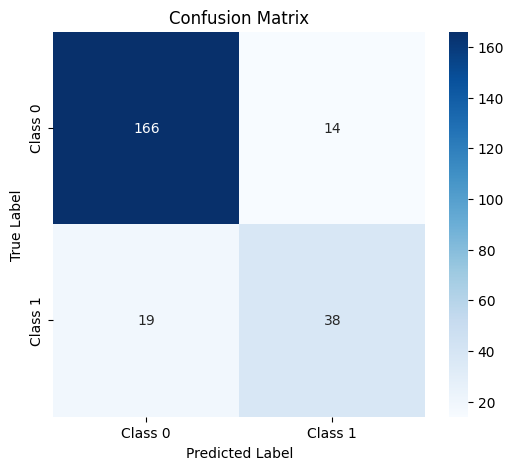

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
# model = tf.keras.models.load_model('/content/gdrive/MyDrive/Applied Ai in Biomedicine/Progetto/VitAIizers/cnn_filtered_notfinetuned_2classes.keras', safe_mode=False)
GML = GaussianMaskLayer()
X_test_masked = GML(X_test)
y_pred_prob = model.predict(X_test_masked)

y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Assuming y_test (true labels) and y_pred_prob (predicted probabilities) are defined
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

# Plot ROC Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='red', lw=2, label=f'PR curve (AP = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()

plt.tight_layout()
plt.show()

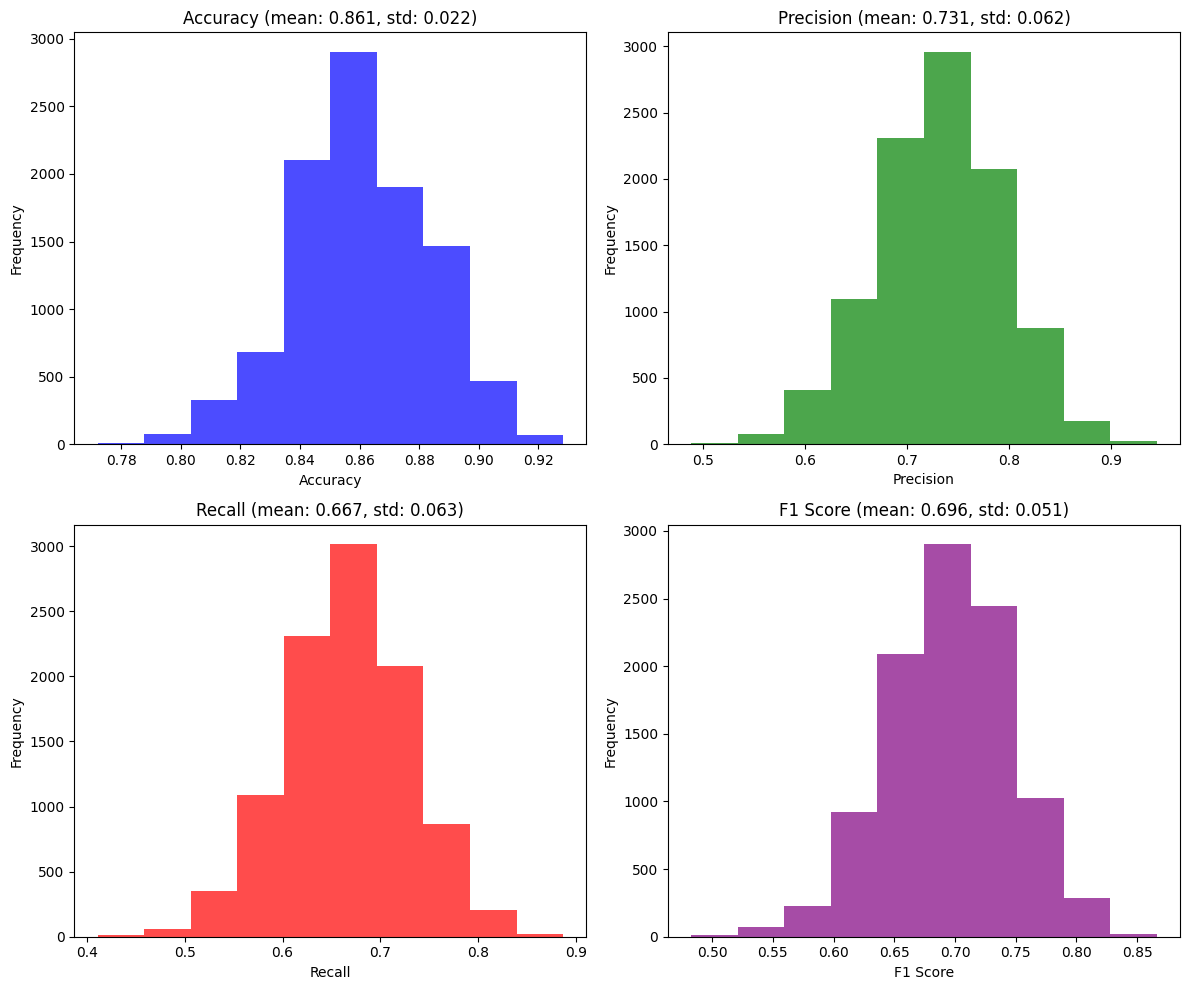

In [ ]:
# Testing using bootstrap:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def bootstrap_metrics(y_pred, y_test, n_iterations=10000):
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for _ in range(n_iterations):
        indices = np.random.choice(len(y_test), size=int(len(y_test)), replace=True)
        y_pred_bootstrap = y_pred[indices]
        y_test_bootstrap = y_test[indices]

        accuracy.append(accuracy_score(y_test_bootstrap, y_pred_bootstrap))
        precision.append(precision_score(y_test_bootstrap, y_pred_bootstrap, average='binary'))
        recall.append(recall_score(y_test_bootstrap, y_pred_bootstrap, average='binary'))
        f1.append(f1_score(y_test_bootstrap, y_pred_bootstrap, average='binary'))

    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = bootstrap_metrics(y_pred, y_test)


metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

means = {metric: np.mean(values) for metric, values in metrics.items()}
std_devs = {metric: np.std(values) for metric, values in metrics.items()}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].hist(accuracy, alpha=0.7, color='blue')
axes[0, 0].set_title(f'Accuracy (mean: {means["Accuracy"]:.3f}, std: {std_devs["Accuracy"]:.3f})')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(precision, alpha=0.7, color='green')
axes[0, 1].set_title(f'Precision (mean: {means["Precision"]:.3f}, std: {std_devs["Precision"]:.3f})')
axes[0, 1].set_xlabel('Precision')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(recall, alpha=0.7, color='red')
axes[1, 0].set_title(f'Recall (mean: {means["Recall"]:.3f}, std: {std_devs["Recall"]:.3f})')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(f1, alpha=0.7, color='purple')
axes[1, 1].set_title(f'F1 Score (mean: {means["F1 Score"]:.3f}, std: {std_devs["F1 Score"]:.3f})')
axes[1, 1].set_xlabel('F1 Score')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# LIME

In [ ]:
!pip install lime

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Applied Ai in Biomedicine/Progetto/VitAIizers/cnn_filtered_notfinetuned_2classes.keras', safe_mode=False)
GML = GaussianMaskLayer()
X_test_masked = GML(X_test).numpy()

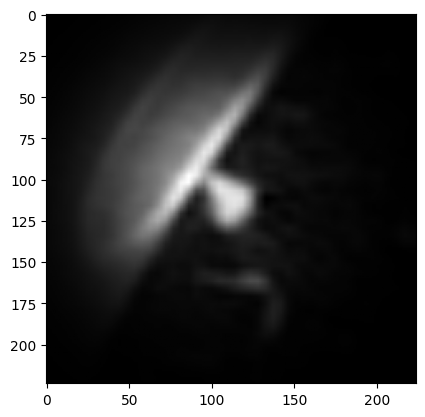

In [ ]:
idx = 1
sample = X_test_masked[idx]
plt.imshow(sample, cmap = "gray")

In [ ]:
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
from lime import lime_image

sample = X_test_masked[idx]

sample_rgb = np.repeat(sample, 3, axis=-1)

def predict_fn(images):
    images_gray = np.mean(images, axis=-1, keepdims=True)  # Convert back to grayscale by averaging the channels
    return model.predict(images_gray, verbose = 0)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(sample_rgb, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

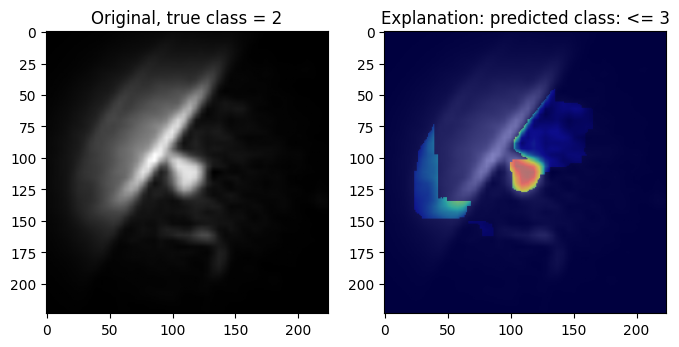

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.imshow(sample.squeeze(), cmap='gray')
plt.title(f"Original, true class = {y_test_complete[idx]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sample.squeeze(), cmap='gray')
plt.imshow(temp[:,:,0], cmap = "jet", alpha = 0.5)
plt.title(f"Explanation: predicted class:")
plt.axis("off")

plt.show()